In [1]:
import spatialdata as sd
import spatialdata_plot  # noqa: F401

/home/stefar/Documents/Spatial Transcriptomic/.venv/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


Here I import the data. The dataset contains 1 large microscopy image represented as multiscale, chunked image, two explicit downscaled versions of it and one CytAssist image.
Also the image dataset contains the data at the highest resolution (2um) and two downsampled versions of it (8um and 16 um)

In [2]:
data_path = "data.zarr"
sdata = sd.read_zarr(data_path)
sdata

/tmp/ipykernel_4224/1799439451.py:2: UserWarning: SpatialData is not stored in the most current format. If you want to use Zarr v3, please write the store to a new location using `sdata.write()`.
  sdata = sd.read_zarr(data_path)
/home/stefar/Documents/Spatial Transcriptomic/.venv/lib/python3.11/site-packages/zarr/core/group.py:3535: ZarrUserWarning: Object at zmetadata is not recognized as a component of a Zarr hierarchy.
  warnings.warn(


SpatialData object, with associated Zarr store: /home/stefar/Documents/Spatial Transcriptomic/data.zarr
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_cytassist_image': DataArray[cyx] (3, 3000, 3198)
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (351817, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (91033, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (5479660, 19059)
      ├── 'square_008um': AnnData (351817, 19059)
      └── 'square_016um': AnnDa

# Lets visualize the images


In [4]:
import matplotlib.pyplot as plt

INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_lowres' since it doesn't have      
         relevant elements.                                                                                        
INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_hires' since it doesn't have       
         relevant elements.                                                                                        
INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_lowres' since it doesn't have      
         relevant elements.                                                                                        
INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_hires' since it doesn't have       
         relevant elements.                                                                                        
INFO     Rasterizing image for faster rendering.                        

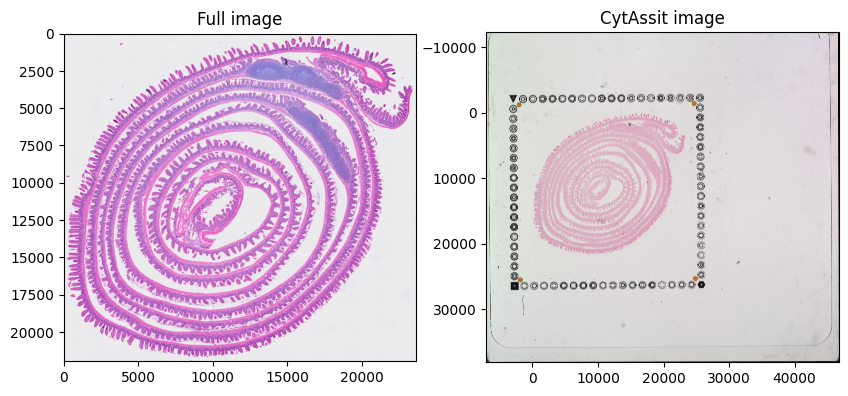

In [6]:
axes = plt.subplots(1,2, figsize=(10,5))[1].flatten()
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(ax=axes[0], title="Full image")
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_cytassist_image").pl.show(ax=axes[1], title="CytAssit image")

2 immagini: la prima ad alta risoluzione la seconda piu bassa
Con la funzione extent otteniamo il rettangolo minimo che racchiude la 1a immagine nel sistema di coordinate.
Dunque con spatialdata.get_extent(img1) ottengo qualcosa del tipo:
-xmin, xmax
-ymin, ymax

Una volta che ho delineato questo rettangolo, viene fatto si che la 2a immagine copra essattamente la stessa area della prima, dunque le 2 immagini possono essere confrontate per quanto riguarda le coordinate spaziali -> le stesse coordinate rappresentano la stessa porzione per le 2 immagini.

In [8]:
from spatialdata import get_extent
data_extent = get_extent(
    sdata["Visium_HD_Mouse_Small_Intestine_full_image"],
    coordinate_system = "Visium_HD_Mouse_Small_Intestine"
)
data_extent

{'y': (np.float64(0.0), np.float64(21943.0)),
 'x': (np.float64(0.0), np.float64(23618.0))}

In [10]:
from spatialdata import bounding_box_query
queried_cytassist = bounding_box_query(
    sdata["Visium_HD_Mouse_Small_Intestine_cytassist_image"],
    min_coordinate = [data_extent["x"][0], data_extent["y"][0]],
    max_coordinate = [data_extent["x"][1], data_extent["y"][1]],
    axes=("x", "y"),
    target_coordinate_system = "Visium_HD_Mouse_Small_Intestine",
)
sdata["queried_cytassist"] = queried_cytassist

INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_lowres' since it doesn't have      
         relevant elements.                                                                                        
INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_hires' since it doesn't have       
         relevant elements.                                                                                        
INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_lowres' since it doesn't have      
         relevant elements.                                                                                        
INFO     Dropping coordinate system 'Visium_HD_Mouse_Small_Intestine_downscaled_hires' since it doesn't have       
         relevant elements.                                                                                        


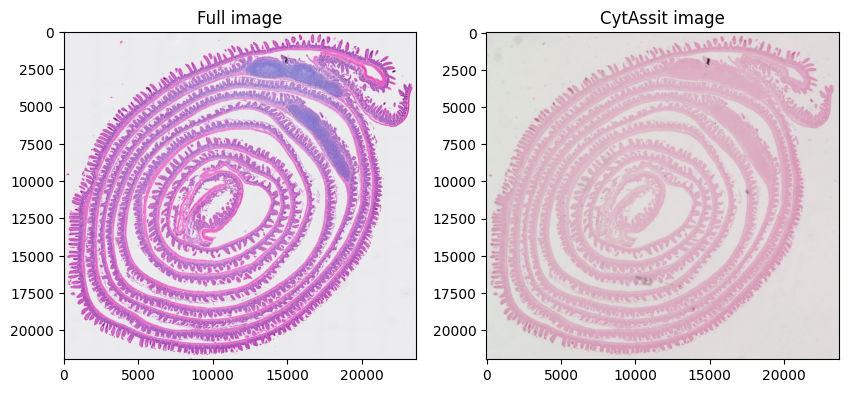

In [12]:
axes = plt.subplots(1,2, figsize=(10, 5))[1].flatten()
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(ax=axes[0], title="Full image")
sdata.pl.render_images("queried_cytassist").pl.show(ax=axes[1], title="CytAssit image")

Ora proviamo a visualizzare una porzione di immagine cosi da apprezzare meglio la risoluzione della prima immagine.

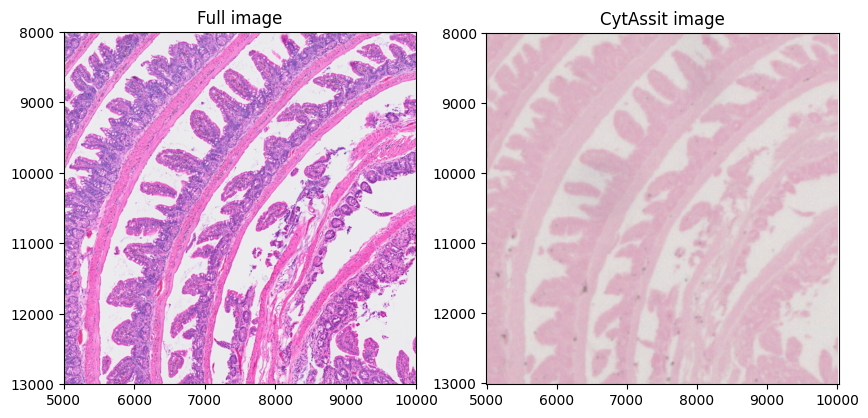

In [14]:
axes = plt.subplots(1,2, figsize=(10,5))[1].flatten()

def crop0(x):
    return bounding_box_query(
        x,
        min_coordinate=[5000,8000],
        max_coordinate=[10000, 13000],
        axes=("x", "y"),
        target_coordinate_system="Visium_HD_Mouse_Small_Intestine",
    )

crop0(sdata).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(
    ax=axes[0], title="Full image", coordinate_systems="Visium_HD_Mouse_Small_Intestine"
)
crop0(sdata).pl.render_images("queried_cytassist").pl.show(
    ax=axes[1], title="CytAssit image", coordinate_systems="Visium_HD_Mouse_Small_Intestine"
)


# Plotting the gene expression data
 Per poter combinare insieme le informazioni degli elementi "shape" e "table" rasterizzo i dati, questa operazione mi permette inoltre di poter rappresentare le immagini in modo piu efficente in termini computazionali

In [5]:
%%time
from spatialdata import rasterize_bins

for bin_size in ["016", "008", "002"]:
    # rasterize_bins() requires a compresed sparse column (csc) matrix
    sdata.tables[f"square_{bin_size}um"].X = sdata.tables[f"square_{bin_size}um"].X.tocsc()
    rasterized = rasterize_bins(
        sdata,
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size}um",
        f"square_{bin_size}um",
        "array_col",
        "array_row",
    )
    sdata[f"rasterized_{bin_size}um"] = rasterized

CPU times: user 43.4 s, sys: 6.36 s, total: 49.7 s
Wall time: 49.7 s


In [42]:
sdata["rasterized_002um"]

<xarray.DataArray 'image' (c: 19059, y: 3285, x: 3191)> Size: 799GB
dask.array<channel_rasterization, shape=(19059, 3285, 3191), dtype=uint32, chunksize=(1, 3285, 3191), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) object 152kB 'Xkr4' 'Rp1' 'Sox17' ... 'mt-Cytb' 'Vamp7'
  * y        (y) float64 26kB 0.5 1.5 2.5 3.5 ... 3.282e+03 3.284e+03 3.284e+03
  * x        (x) float64 26kB 0.5 1.5 2.5 3.5 ... 3.188e+03 3.19e+03 3.19e+03
Attributes:
    transform:  {'Visium_HD_Mouse_Small_Intestine': Sequence \n    Sequence \...

In [6]:
sdata
#qui vediamo che vengono create 3 nuovi immagini rasterizzate
#DataArray [c y x] dove c=canali, in questo caso ogni canale e' un gene
#y x -> altezza e larghezza della griglia raster, cioe' dimensione in pixel dell' area coperta dai bin Visium HD 

/home/stefar/Documents/Spatial Transcriptomic/.venv/lib/python3.11/site-packages/zarr/core/group.py:3535: ZarrUserWarning: Object at zmetadata is not recognized as a component of a Zarr hierarchy.
  warnings.warn(


SpatialData object, with associated Zarr store: /home/stefar/Documents/Spatial Transcriptomic/data.zarr
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_cytassist_image': DataArray[cyx] (3, 3000, 3198)
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     ├── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
│     ├── 'rasterized_002um': DataArray[cyx] (19059, 3285, 3191)
│     ├── 'rasterized_008um': DataArray[cyx] (19059, 822, 799)
│     └── 'rasterized_016um': DataArray[cyx] (19059, 412, 400)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (351817, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016

In [13]:

#seleziono canale -> gene di interesse
gene_name ="AA986860"
#per ogni gene avro una matrice mxn che raprresenta quanto il gene selezionato e' espresso in ciascun bin
sdata["rasterized_002um"].sel(c=gene_name).compute()

<xarray.DataArray 'image' (y: 3285, x: 3191)> Size: 42MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3285, 3191), dtype=float32)
Coordinates:
  * y        (y) float64 26kB 0.5 1.5 2.5 3.5 ... 3.282e+03 3.284e+03 3.284e+03
  * x        (x) float64 26kB 0.5 1.5 2.5 3.5 ... 3.188e+03 3.19e+03 3.19e+03
    c        <U8 32B 'AA986860'
Attributes:
    transform:  {'Visium_HD_Mouse_Small_Intestine': Sequence \n    Sequence \...

CPU times: user 2.93 s, sys: 21.5 ms, total: 2.95 s
Wall time: 3 s


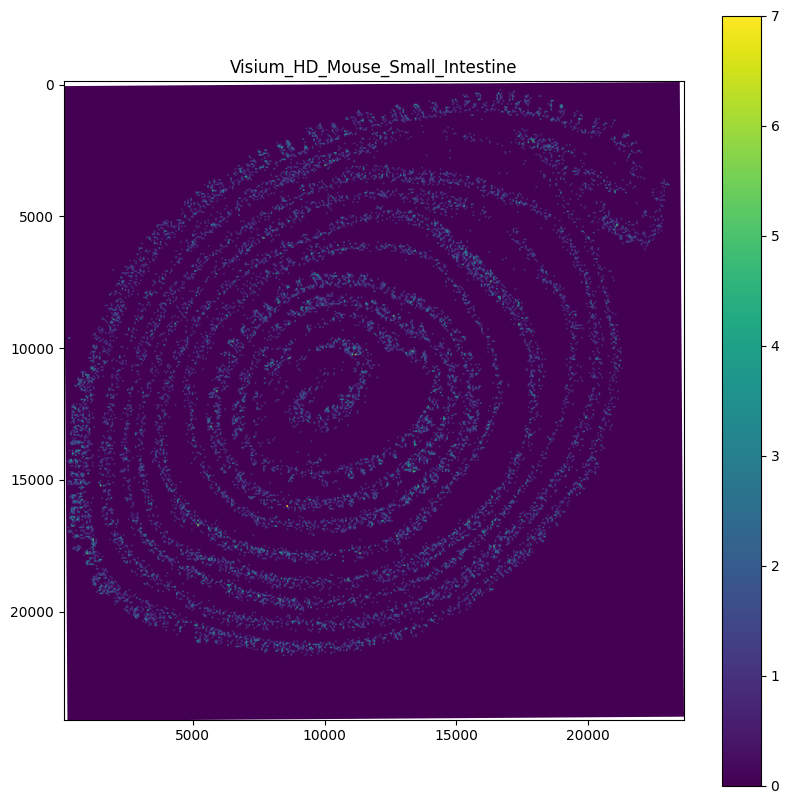

In [15]:
%%time
plt.figure(figsize=(10, 10))
ax = plt.gca()

sdata.pl.render_images("rasterized_016um", channel=gene_name, scale="full").pl.show(
    coordinate_systems="Visium_HD_Mouse_Small_Intestine", ax=ax
)


Note: when we plot the full data below the plot appears as uniformly violet. This happens because the data is very sparse and the bins are too small for the target figure size; since most of the non-zero bins are 1s the final interpolated colors are very close to the zero value and difficult to see.

Let’s therefore:

1.    change the limits of the plot to show a portion of the data to avoid interpolation artifacts

2.    plot a binary mask of the full data to avoid the interpolated data to be to close to 0.


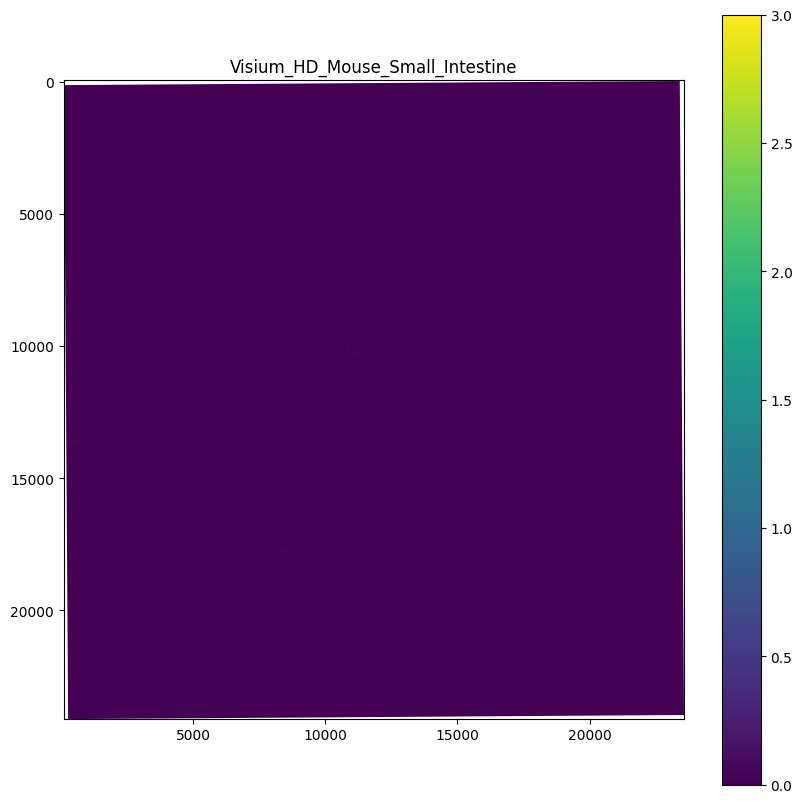

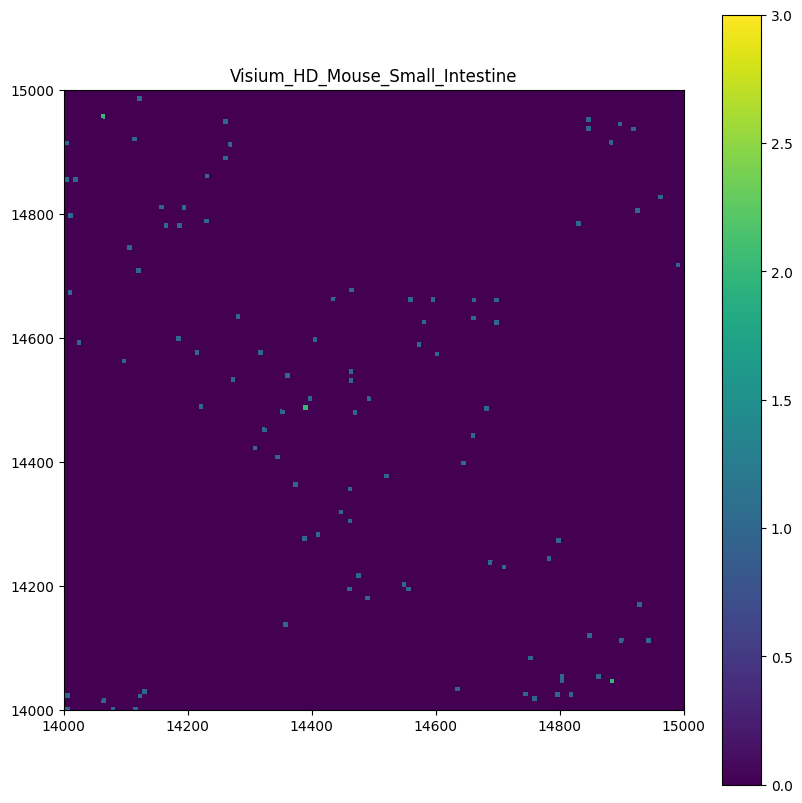

CPU times: user 11 s, sys: 2.04 s, total: 13 s
Wall time: 13 s


In [16]:
%%time

from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

for change_limits in [False, True]:
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    sdata.pl.render_images("rasterized_002um", channel=gene_name, scale="full").pl.show(
        coordinate_systems="Visium_HD_Mouse_Small_Intestine", ax=ax
    )
    sdata["rasterized_002um"]
    if change_limits:
        plt.xlim([14000, 15000])
        plt.ylim([14000, 15000])
plt.show()

# Plotting subset of the data

In [17]:
sdata_small = sdata.query.bounding_box(
    min_coordinate=[7000, 11000],
    max_coordinate=[10000, 14000],
    axes=("x", "y"),
    target_coordinate_system="Visium_HD_Mouse_Small_Intestine",
)


In [18]:
sdata_small #sdata_small subset di sdata

SpatialData object
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_cytassist_image': DataArray[cyx] (3, 179, 179)
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 3000, 3000), (3, 1500, 1500), (3, 750, 750), (3, 374, 375), (3, 188, 188)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 763, 762)
│     ├── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 77, 76)
│     ├── 'rasterized_002um': DataArray[cyx] (19059, 413, 413)
│     ├── 'rasterized_008um': DataArray[cyx] (19059, 103, 103)
│     └── 'rasterized_016um': DataArray[cyx] (19059, 51, 51)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (143870, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (9311, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (2417, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (143870, 19059)


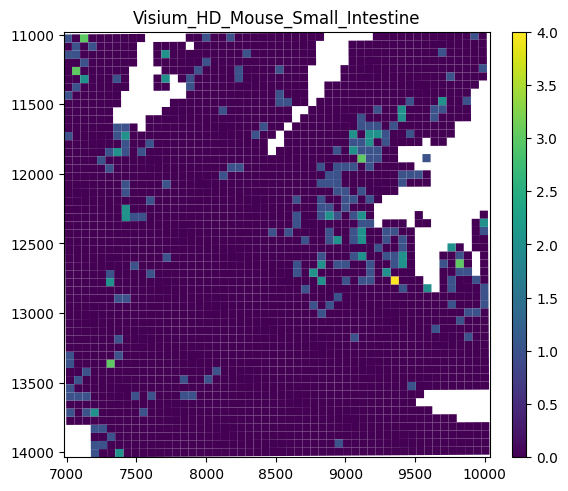

In [19]:
gene_name = "AA986860"
sdata_small.pl.render_shapes("Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name).pl.show(
    coordinate_systems="Visium_HD_Mouse_Small_Intestine"
)

Notice how a Moiré pattern is visible. This is due to the fact that the grid is not axis-aligned but presents a small rotation. A solution is to switch to datashader as a backend (which is enabled by default when the number of geometries is large). This will create some artifacts (bins of different sizes, some “holes” in the plot), but generally is expected to mitigate the effects as opposed the plot above.

INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' to disable this behaviour.   
INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      


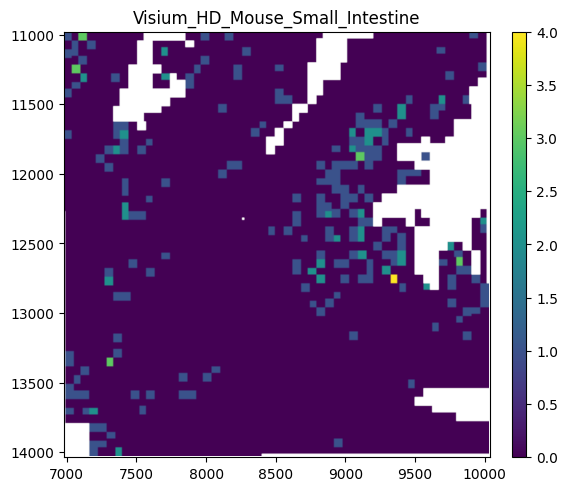

In [20]:
gene_name = "AA986860"
sdata_small.pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name, method="datashader"
).pl.show(coordinate_systems="Visium_HD_Mouse_Small_Intestine")


INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' to disable this behaviour.   
INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      
INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' to disable this behaviour.   
INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      
INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' to disable this behaviour.   
INFO     Using the datashader reduction "sum". "max" will give an output

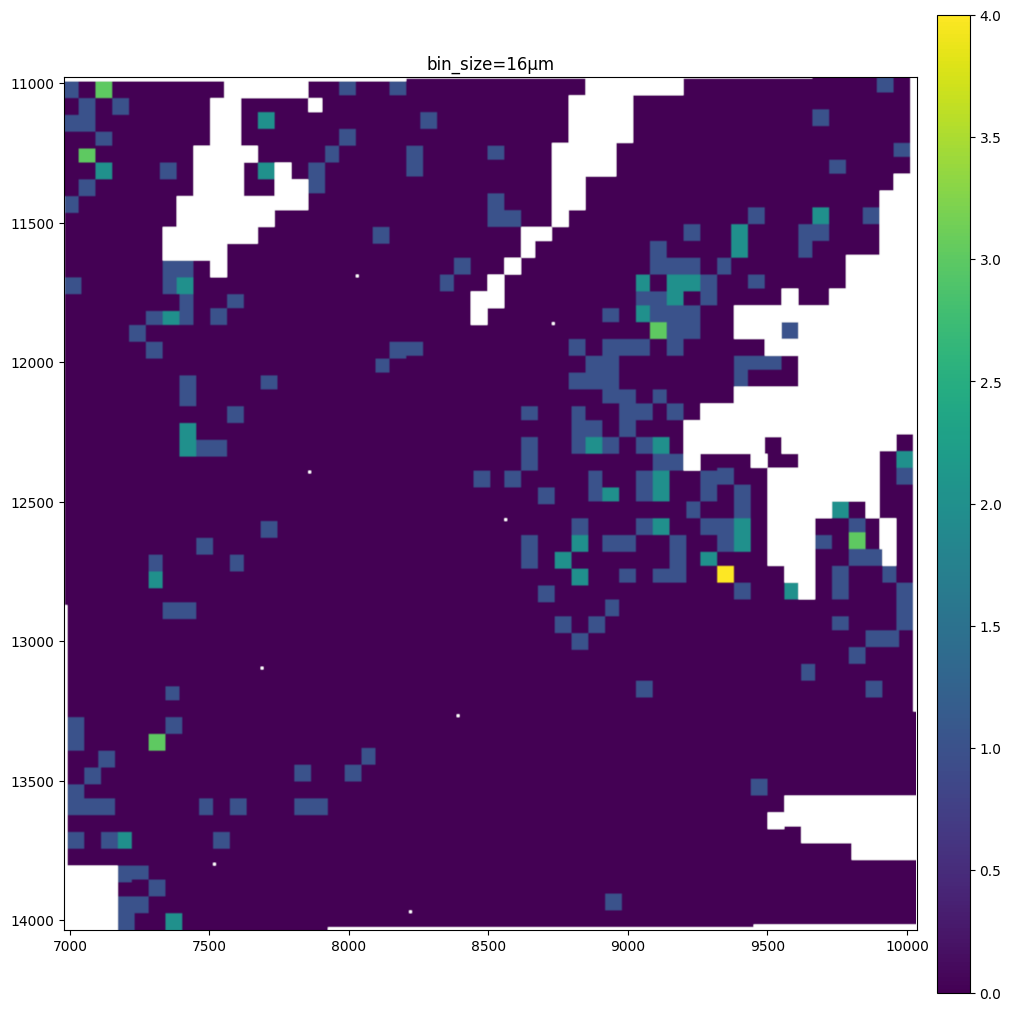

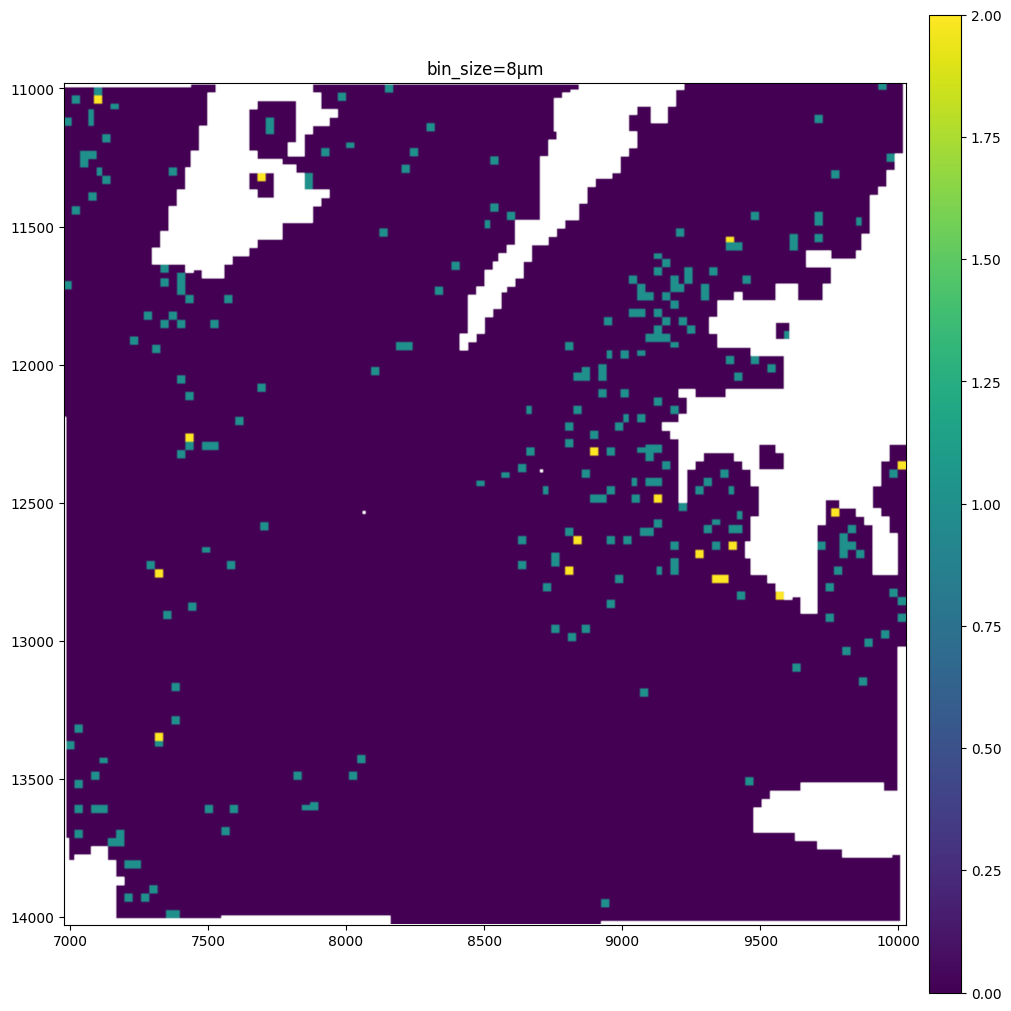

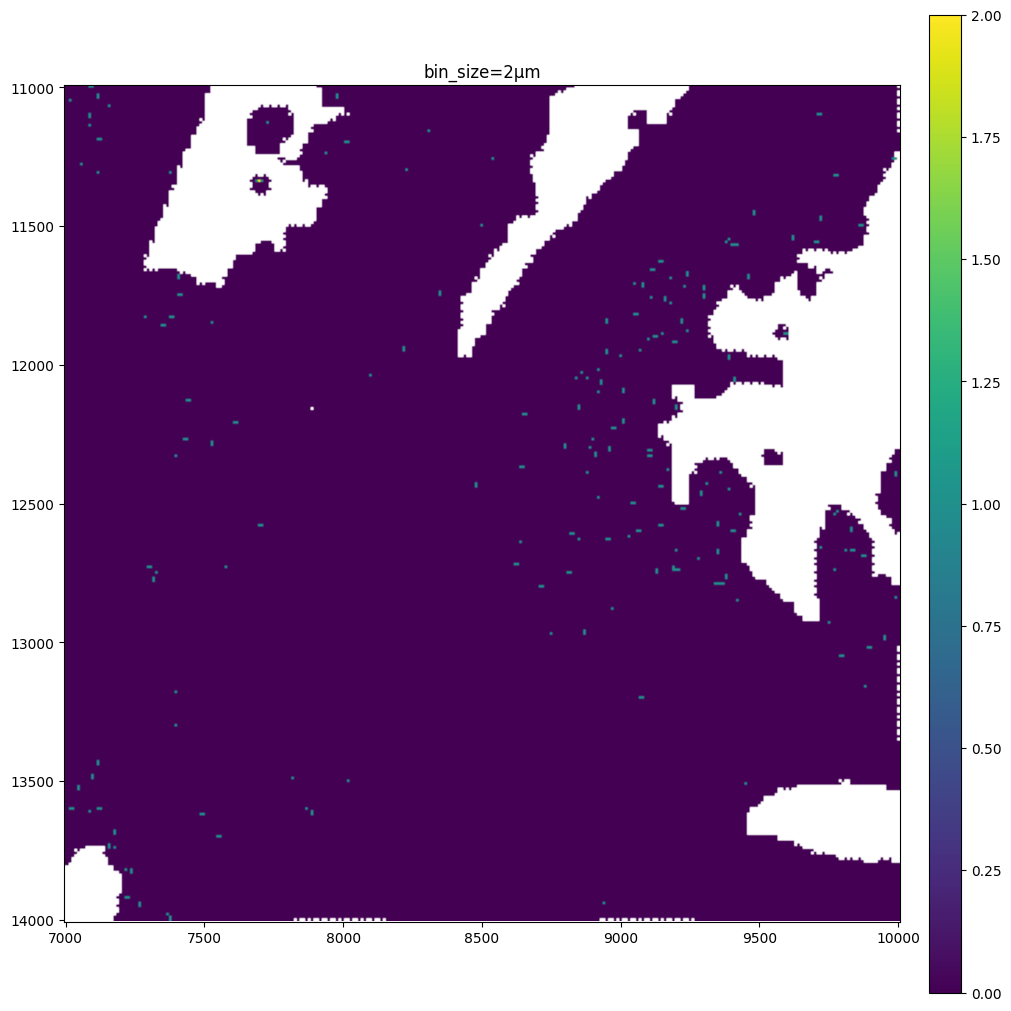

In [21]:
#ora raprresentiamo graficamente le porzioni di immagini con bin_size differenti
gene_name = "AA986860"

for bin_size in [16, 8, 2]:
    sdata_small.pl.render_shapes(
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size:03}um",
        color=gene_name,
        method="datashader",
    ).pl.show(coordinate_systems="Visium_HD_Mouse_Small_Intestine", title=f"bin_size={bin_size}µm", figsize=(10, 10))

The data present a lot of sparsity. Let’s remake the plots above by visualizing only the non-zero entries and using the full-resolution image as a background.

We will do this by modifying the viridis colormap so that 0 is plotted as transparent. Let’s also truncate the viridis colormap so that the highest value is colored green and not yellow since green has a better contrast against the pink of the H&E microscopy image.

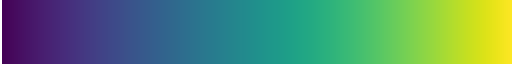

In [22]:
# let's display the areas where no expression is detected as transparent
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")
new_cmap

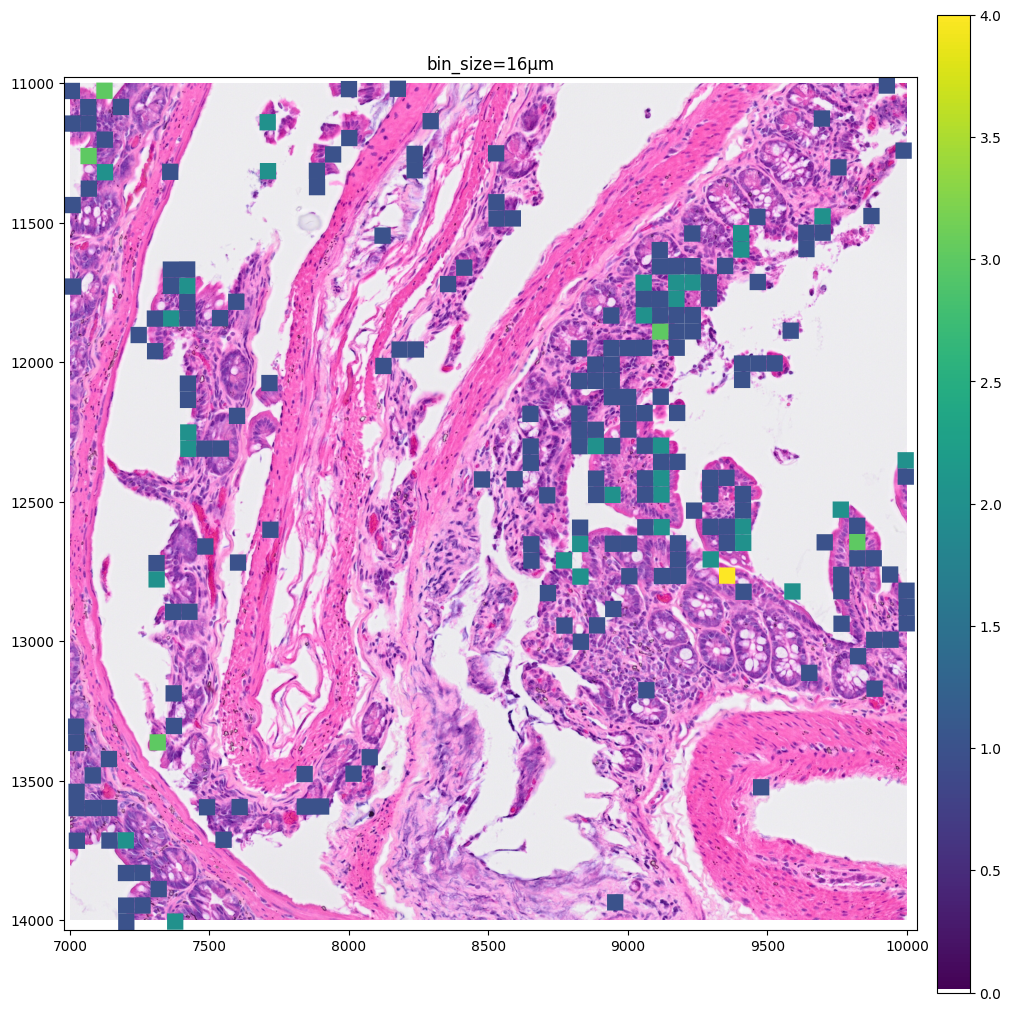

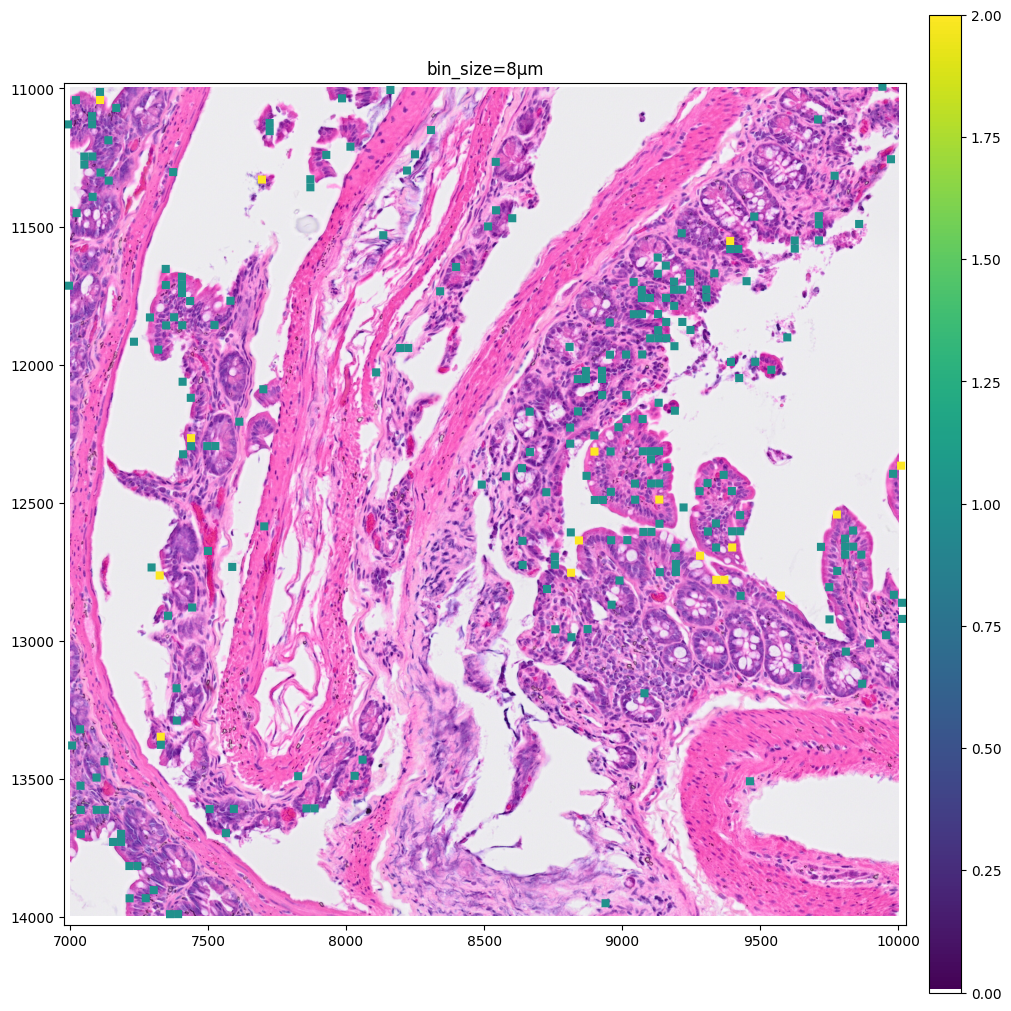

In [24]:
gene_name = "AA986860"

for bin_size in [16, 8]:
    sdata_small.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size:03}um", color=gene_name, cmap=new_cmap #bin_size_03 cotruisce dinamicamente il numero corretto a 3 cifre, eg: 008, 016
    ).pl.show(coordinate_systems="Visium_HD_Mouse_Small_Intestine", title=f"bin_size={bin_size}µm", figsize=(10, 10))


# Interactive Visualization with Napari
Currently napari’s performance is not optimized for the visualization of large collections of polygonal data (we are working on improving this together with the napari developers).
One way to improve the performance is to convert the polygonal data to simpler vector representations, such as circles or points. This can be achieved via the to_circles() and get_centroids() spatialdata APIs. But a better approach is to switch to a raster-based visualization.

Raster-based visualization

To overcome the above limitations, you can proceed with the on-demand rasterization approach that we explained above by simply selecting the rasterized_002um, rasterized_008um, and rasterized_016um layers.


In [31]:
sdata.images["rasterized_002um"]

<xarray.DataArray 'image' (c: 19059, y: 3285, x: 3191)> Size: 799GB
dask.array<channel_rasterization, shape=(19059, 3285, 3191), dtype=uint32, chunksize=(1, 3285, 3191), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) object 152kB 'Xkr4' 'Rp1' 'Sox17' ... 'mt-Cytb' 'Vamp7'
  * y        (y) float64 26kB 0.5 1.5 2.5 3.5 ... 3.282e+03 3.284e+03 3.284e+03
  * x        (x) float64 26kB 0.5 1.5 2.5 3.5 ... 3.188e+03 3.19e+03 3.19e+03
Attributes:
    transform:  {'Visium_HD_Mouse_Small_Intestine': Sequence \n    Sequence \...

In [44]:
# the 'rasterize_002um' image, and the `new_cmap` variable have been created ealier in the notebook
# below we open napari in headless-mode and preload a layer, then we programmatically set a custom colormap

from napari.utils.colormaps import Colormap
from napari_spatialdata import Interactive

napari_cmap = Colormap(new_cmap.colors, "viridis_zero_transparent")

interactive = Interactive(sdata, headless=True)
interactive.add_element(f"rasterized_002um", "global", view_element_system=True)
interactive.get_layer(f"rasterized_002um").colormap = napari_cmap
interactive.run()

2026-01-28 12:13:06.346 | WARNING  | napari_spatialdata._viewer:__init__:57 - Due to Shift-L being used as shortcut in napari, it is being deprecated and might not link a new layer to an existing SpatialData object in the viewer. Please use ⌘-L on MacOS or else Ctrl-L.


ValueError: Element rasterized_002um not found in coordinate system rasterized_002um.